<a href="https://colab.research.google.com/github/MuhammedUmerNazir/CV_Semantic_Segmentation_A3/blob/main/CV_Assign_3_Task_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Computer Vision Assignment 3**
## Name: Muhammed Umer Nazir
## Roll Number: 399874
### Task 1 

In this task we will use UNET as the baseline alongwith VGG19 as the backbone.
## Importing Packages

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm
!pip install -q torchsummary

from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Dataset Preprocessing

### Cityspace Dataset

The dataset is a subset of Cityspace Dataset and has already been divided into train and test splits.
For validation, we can further 80%--20% split the train part.
**Following classes are there in the dataset.**

"Sky", "Building", "Pole","Road","Pavement","Tree","SignSymbol", "Fence", "Car",
"Pedestrian", "Bicyclist"

In [ ]:
# Downloading dataset
!gdown https://drive.google.com/file/d/1-9KNRTrsjQetmwT4Kamx391YEwkC43ue/view?usp=sharing --fuzzy

Downloading...
From: https://drive.google.com/uc?id=1-9KNRTrsjQetmwT4Kamx391YEwkC43ue
To: /content/A3_Dataset.zip
100% 126M/126M [00:01<00:00, 62.9MB/s]


In [ ]:
# Unzipping downloaded dataset
!unzip "/content/A3_Dataset.zip"

Archive:  /content/A3_Dataset.zip
   creating: A3_Dataset/
   creating: A3_Dataset/dataset1/
   creating: A3_Dataset/dataset1/annotations_prepped_test/
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07959.png  
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07961.png  
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07963.png  
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07965.png  
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07967.png  
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07969.png  
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07971.png  
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07973.png  
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07975.png  
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07977.png  
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07979.png  
 

In [ ]:
# Defining paths to dataset
MASK_PATH = "./A3_Dataset/dataset1/annotations_prepped_train/"
IMAGE_PATH = "./A3_Dataset/dataset1/images_prepped_train/"
MASK_PATH_TEST = "./A3_Dataset/dataset1/annotations_prepped_test/"
IMAGE_PATH_TEST = "./A3_Dataset/dataset1/images_prepped_test/"

In [ ]:
# Counting the training and test images
n_classes = 12 
def create_df(path):
    name = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            name.append(filename.split('.')[0])

    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

X_trainval = create_df(IMAGE_PATH)
print('Train Images: ', len(X_trainval))

X_test = create_df(IMAGE_PATH_TEST)
print('Test Images: ', len(X_test))

Train Images:  367
Test Images:  101


In [ ]:
# Splitting dataset into Training, Validation and Testing sets
X_test = X_test['id'].values
X_train, X_val = train_test_split(X_trainval['id'].values, test_size=0.15, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Train Size   :  311
Val Size     :  56
Test Size    :  101


In [ ]:
import matplotlib
print(matplotlib.rcParams['image.cmap'])

viridis


Image Size (360, 480, 3)
Mask Size (360, 480)


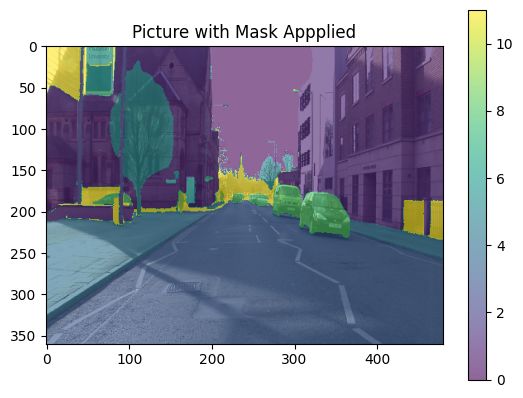

In [ ]:
# Viewing an example image from dataset
img = Image.open(IMAGE_PATH + '/' + X_trainval['id'][101] + '.png')
mask = Image.open(MASK_PATH + '/' + X_trainval['id'][101] + '.png')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)

plt.imshow(img, cmap = 'viridis')
msk = plt.imshow(mask, alpha=0.6, cmap ='viridis')
plt.title('Picture with Mask Appplied')
#plt.show()

# Add a colorbar to show the mapping between colors and data values
plt.colorbar(msk)

# Show the plot
plt.show()

In [ ]:
# Defining class for given dataset
from torchvision import transforms as T

class CityDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, mean, std, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()
            
        return img, mask

In [ ]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

# Data Augmentation

# Resizing, Rotating and Noise Removal
t_train = A.Compose([A.Resize(256, 256, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(),
                     A.GaussNoise()])

# Interpolating the dataset
t_val = A.Compose([A.Resize(256, 256, interpolation=cv2.INTER_NEAREST)])

# Datasets
train_set = CityDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train)
val_set = CityDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val)

# Dataloader
batch_size= 16

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

## Importing Model Architecture

In [ ]:
!pip install -q segmentation-models-pytorch
import segmentation_models_pytorch as smp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.3 MB/s eta 0:00:00


In [ ]:
# In this task, Task 1, we are using UNET as the baseline and VGG19 as Backbone
model = smp.Unet('vgg19', encoder_weights='imagenet', classes=12, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 86.7MB/s]


In [ ]:
# Calculating pixel accuracy over a batch of images
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [ ]:
# Calculating mean Intersection-over-Union over a batch of images
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=5):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

## Training Model Architecture

In [ ]:
# Inner loop for running the model for 1 epoch over a given loader
def run_1_epoch(model, loss_fn, loader, optimizer = None, train = False):
  
  if train:
    model.train()
  else:
    model.eval()

  total_correct_preds = 0
  
  total_loss = 0

  # Number of images we can get by the loader
  total_samples_in_loader = len(loader.dataset)
  
  # number of batches we can get by the loader 
  total_batches_in_loader = len(loader)

  for image_batch, labels in tqdm(loader):
    
    # Transfer image_batch to GPU if available
    image_batch = image_batch.to(device)
    labels = labels.to(device)
    
    # Zeroing out the gradients for parameters
    if train:
      assert optimizer is not None, "Optimizer must be provided if train=True"
      optimizer.zero_grad()
    
    # Forward pass on the input batch
    output = model(image_batch)

    # Acquire predicted class indices
    _, predicted = torch.max(output.data, 1) # the dimension 1 corresponds to max along the rows 
    
    # Removing extra last dimension from output tensor
    #output.squeeze_(-1)

    # Compute the loss for the minibatch
    loss = loss_function(output, labels)
    
    # Backpropagation
    if train:
      loss.backward()
    
    # Update the parameters using the gradients
    if train:
      optimizer.step()
    
    # Extra variables for calculating loss and accuracy
    # count total predictions for accuracy calcutuon for this epoch
    #total_correct_preds += (predicted == labels).sum().item()

    total_loss += loss.item()

  loss = total_loss / total_batches_in_loader
  accuracy = pixel_accuracy(output, labels)
  mean_IoU = mIoU(output, labels)

  return loss, accuracy, mean_IoU

### Training Configuration

In [ ]:
# Select a loss function
loss_function = torch.nn.CrossEntropyLoss()

# Select an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Define the learning rate scheduler
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Set the number of epochs
# This variable is used in the main training loop
epochs = 40

model.to(device);

In [ ]:
# Initializing variables for starting a new training
# Some helper variables

train_accuracies = []
val_accuracies = []

train_losses = []
val_losses = []

train_mIoUs = []
val_mIoUs = []

val_mIoU_max = -1

checkpoint_path = '/content/Pre-Trained_Models/checkpoint_norm_aug_tensorboard.pth'
best_val_checkpoint_path = '/content/Pre-Trained_Models/best_val_checkpoint_norm_aug_tensorboard.pth'

# Start epoch is zero for new training
start_epoch = 0

### Main training loop

In [ ]:
# Main training and validation loop for n number of epochs
for epoch in range(start_epoch, epochs):

  # Train model for one epoch

  # Get the current learning rate from the optimizer
  current_lr = optimizer.param_groups[0]['lr']

  print("Epoch %d: Train \nLearning Rate: %.6f"%(epoch, current_lr))
  train_loss, train_accuracy, train_mIoU  = run_1_epoch(model, loss_function, train_loader, optimizer, train= True)

  # Update the learning rate scheduler
  scheduler.step()

  # Lists for train loss and accuracy for plotting
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)
  train_mIoUs.append(train_mIoU)

  # Validate the model on validation set
  print("Epoch %d: Validation"%(epoch))
  with torch.no_grad():
    val_loss, val_accuracy, val_mIoU  = run_1_epoch(model, loss_function, val_loader, optimizer, train= False)
  
  # Lists for val loss and accuracy for plotting
  val_losses.append(val_loss)
  val_accuracies.append(val_accuracy)
  val_mIoUs.append(val_mIoU)

  # The "add_scalar" function adds a new metric to the tensorboard log
  # It is gnerally given 3 arguments:
  # tag: Name of the metric
  # scalar_value = the value of the metric to record
  # global_step = on which milestone to record the scalar value which in our
  # case is the epoch
  # writer.add_scalar(tag = "Loss/train", scalar_value = train_loss, global_step = epoch)
  # writer.add_scalar(tag = "accuracy/train", scalar_value = train_accuracy, global_step = epoch)

  # writer.add_scalar(tag = "Loss/val", scalar_value = val_loss, global_step = epoch)
  # writer.add_scalar(tag = "accuracy/val", scalar_value = val_accuracy, global_step = epoch)

  print('train loss: %.4f'%(train_loss))
  print('val loss: %.4f'%(val_loss))
  print('train_accuracy %.2f' % (train_accuracy))
  print('val_accuracy %.2f' % (val_accuracy))
  print('train_IoU %.2f'%(train_mIoU))
  print('val_IoU %.2f'%(val_mIoU))
  
  # Save model if validation accuracy for current epoch is greater than 
  # all the previous epochs 
  if val_mIoU > val_mIoU_max:
    val_mIoU_max = val_mIoU
    print("New max val mean IoU Acheived %.2f. Saving model.\n\n"%(val_mIoU_max))

    checkpoint = {
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'scheduler': scheduler.state_dict(),
    'trianed_epochs': epoch,
    'train_losses': train_losses,
    'train_accuracies': train_accuracies,
    'train_mIoUs': train_mIoUs,
    'val_losses': val_losses,
    'val_accuracies': val_accuracies,
    'val_accuracy_max': val_mIoU_max,
    'val_mIoUs': val_mIoUs,
    'lr': optimizer.param_groups[0]['lr']
    }
    torch.save(checkpoint, best_val_checkpoint_path)

  else:
    print("val mean IoU did not increase from %.2f\n\n"%(val_mIoU_max))

  # Save checkpoint for the last epoch
  checkpoint = {
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'scheduler': scheduler.state_dict(),
    'trianed_epochs': epoch,
    'train_losses': train_losses,
    'train_accuracies': train_accuracies,
    'train_mIoUs': train_mIoUs,
    'val_losses': val_losses,
    'val_accuracies': val_accuracies,
    'val_accuracy_max': val_mIoU_max,
    'val_mIoUs': val_mIoUs,
    'lr': optimizer.param_groups[0]['lr']
    }

  torch.save(checkpoint, checkpoint_path)

  

Epoch 0: Train 
Learning Rate: 0.000100


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0: Validation


  0%|          | 0/4 [00:00<?, ?it/s]

train loss: 2.3794
val loss: 2.1375
train_accuracy 0.33
val_accuracy 0.34
train_IoU 0.16
val_IoU 0.15
New max val mean IoU Acheived 0.15. Saving model.


Epoch 1: Train 
Learning Rate: 0.000100


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1: Validation


  0%|          | 0/4 [00:00<?, ?it/s]

train loss: 1.8055
val loss: 1.6290
train_accuracy 0.59
val_accuracy 0.54
train_IoU 0.35
val_IoU 0.29
New max val mean IoU Acheived 0.29. Saving model.


Epoch 2: Train 
Learning Rate: 0.000100


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2: Validation


  0%|          | 0/4 [00:00<?, ?it/s]

train loss: 1.3974
val loss: 1.3163
train_accuracy 0.74
val_accuracy 0.72
train_IoU 0.41
val_IoU 0.46
New max val mean IoU Acheived 0.46. Saving model.


Epoch 3: Train 
Learning Rate: 0.000100


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3: Validation


  0%|          | 0/4 [00:00<?, ?it/s]

train loss: 1.1721
val loss: 1.1776
train_accuracy 0.84
val_accuracy 0.76
train_IoU 0.57
val_IoU 0.50
New max val mean IoU Acheived 0.50. Saving model.


Epoch 4: Train 
Learning Rate: 0.000100


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4: Validation


  0%|          | 0/4 [00:00<?, ?it/s]

train loss: 1.0268
val loss: 1.0374
train_accuracy 0.84
val_accuracy 0.78
train_IoU 0.58
val_IoU 0.56
New max val mean IoU Acheived 0.56. Saving model.


Epoch 5: Train 
Learning Rate: 0.000100


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5: Validation


  0%|          | 0/4 [00:00<?, ?it/s]

train loss: 0.9096
val loss: 0.9548
train_accuracy 0.87
val_accuracy 0.78
train_IoU 0.64
val_IoU 0.59
New max val mean IoU Acheived 0.59. Saving model.


Epoch 6: Train 
Learning Rate: 0.000100


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 6: Validation


  0%|          | 0/4 [00:00<?, ?it/s]

train loss: 0.8361
val loss: 0.8717
train_accuracy 0.84
val_accuracy 0.82
train_IoU 0.58
val_IoU 0.61
New max val mean IoU Acheived 0.61. Saving model.


Epoch 7: Train 
Learning Rate: 0.000100


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 7: Validation


  0%|          | 0/4 [00:00<?, ?it/s]

train loss: 0.7655
val loss: 0.8107
train_accuracy 0.86
val_accuracy 0.88
train_IoU 0.64
val_IoU 0.65
New max val mean IoU Acheived 0.65. Saving model.


Epoch 8: Train 
Learning Rate: 0.000100


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 8: Validation


  0%|          | 0/4 [00:00<?, ?it/s]

train loss: 0.7063
val loss: 0.7515
train_accuracy 0.87
val_accuracy 0.86
train_IoU 0.62
val_IoU 0.62
val mean IoU did not increase from 0.65


Epoch 9: Train 
Learning Rate: 0.000100


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 9: Validation


  0%|          | 0/4 [00:00<?, ?it/s]

train loss: 0.6643
val loss: 0.7103
train_accuracy 0.86
val_accuracy 0.87
train_IoU 0.67
val_IoU 0.67
New max val mean IoU Acheived 0.67. Saving model.


Epoch 10: Train 
Learning Rate: 0.000010


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 10: Validation


  0%|          | 0/4 [00:00<?, ?it/s]

train loss: 0.6351
val loss: 0.6905
train_accuracy 0.84
val_accuracy 0.86
train_IoU 0.61
val_IoU 0.65
val mean IoU did not increase from 0.67


Epoch 11: Train 
Learning Rate: 0.000010


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 11: Validation


  0%|          | 0/4 [00:00<?, ?it/s]

train loss: 0.6172
val loss: 0.6822
train_accuracy 0.91
val_accuracy 0.87
train_IoU 0.69
val_IoU 0.65
val mean IoU did not increase from 0.67


Epoch 12: Train 
Learning Rate: 0.000010


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 12: Validation


  0%|          | 0/4 [00:00<?, ?it/s]

train loss: 0.6169
val loss: 0.6734
train_accuracy 0.88
val_accuracy 0.88
train_IoU 0.66
val_IoU 0.67
New max val mean IoU Acheived 0.67. Saving model.


Epoch 13: Train 
Learning Rate: 0.000010


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 13: Validation


  0%|          | 0/4 [00:00<?, ?it/s]

train loss: 0.6111
val loss: 0.6711
train_accuracy 0.84
val_accuracy 0.87
train_IoU 0.62
val_IoU 0.66
val mean IoU did not increase from 0.67


Epoch 14: Train 
Learning Rate: 0.000010


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 14: Validation


  0%|          | 0/4 [00:00<?, ?it/s]

train loss: 0.6065
val loss: 0.6709
train_accuracy 0.84
val_accuracy 0.85
train_IoU 0.65
val_IoU 0.64
val mean IoU did not increase from 0.67


Epoch 15: Train 
Learning Rate: 0.000010


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 15: Validation


  0%|          | 0/4 [00:00<?, ?it/s]

train loss: 0.5998
val loss: 0.6518
train_accuracy 0.92
val_accuracy 0.90
train_IoU 0.70
val_IoU 0.69
New max val mean IoU Acheived 0.69. Saving model.


Epoch 16: Train 
Learning Rate: 0.000010


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 16: Validation


  0%|          | 0/4 [00:00<?, ?it/s]

train loss: 0.5970
val loss: 0.6543
train_accuracy 0.90
val_accuracy 0.87
train_IoU 0.66
val_IoU 0.68
val mean IoU did not increase from 0.69


Epoch 17: Train 
Learning Rate: 0.000010


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 17: Validation


  0%|          | 0/4 [00:00<?, ?it/s]

train loss: 0.5923
val loss: 0.6580
train_accuracy 0.89
val_accuracy 0.85
train_IoU 0.66
val_IoU 0.65
val mean IoU did not increase from 0.69


Epoch 18: Train 
Learning Rate: 0.000010


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 18: Validation


  0%|          | 0/4 [00:00<?, ?it/s]

train loss: 0.5863
val loss: 0.6525
train_accuracy 0.90
val_accuracy 0.86
train_IoU 0.68
val_IoU 0.65
val mean IoU did not increase from 0.69


Epoch 19: Train 
Learning Rate: 0.000010


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 19: Validation


  0%|          | 0/4 [00:00<?, ?it/s]

train loss: 0.5802
val loss: 0.6481
train_accuracy 0.89
val_accuracy 0.85
train_IoU 0.67
val_IoU 0.62
val mean IoU did not increase from 0.69


Epoch 20: Train 
Learning Rate: 0.000001


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 20: Validation


  0%|          | 0/4 [00:00<?, ?it/s]

train loss: 0.5786
val loss: 0.6412
train_accuracy 0.89
val_accuracy 0.87
train_IoU 0.68
val_IoU 0.65
val mean IoU did not increase from 0.69


Epoch 21: Train 
Learning Rate: 0.000001


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 21: Validation


  0%|          | 0/4 [00:00<?, ?it/s]

train loss: 0.5749
val loss: 0.6462
train_accuracy 0.91
val_accuracy 0.86
train_IoU 0.66
val_IoU 0.65
val mean IoU did not increase from 0.69


Epoch 22: Train 
Learning Rate: 0.000001


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 22: Validation


  0%|          | 0/4 [00:00<?, ?it/s]

train loss: 0.5832
val loss: 0.6423
train_accuracy 0.89
val_accuracy 0.87
train_IoU 0.67
val_IoU 0.67
val mean IoU did not increase from 0.69


Epoch 23: Train 
Learning Rate: 0.000001


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 23: Validation


  0%|          | 0/4 [00:00<?, ?it/s]

train loss: 0.5742
val loss: 0.6241
train_accuracy 0.88
val_accuracy 0.92
train_IoU 0.67
val_IoU 0.69
New max val mean IoU Acheived 0.69. Saving model.


Epoch 24: Train 
Learning Rate: 0.000001


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 24: Validation


  0%|          | 0/4 [00:00<?, ?it/s]

train loss: 0.5764
val loss: 0.6300
train_accuracy 0.88
val_accuracy 0.90
train_IoU 0.65
val_IoU 0.68
val mean IoU did not increase from 0.69


Epoch 25: Train 
Learning Rate: 0.000001


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 25: Validation


  0%|          | 0/4 [00:00<?, ?it/s]

train loss: 0.5757
val loss: 0.6366
train_accuracy 0.89
val_accuracy 0.88
train_IoU 0.66
val_IoU 0.67
val mean IoU did not increase from 0.69


Epoch 26: Train 
Learning Rate: 0.000001


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 26: Validation


  0%|          | 0/4 [00:00<?, ?it/s]

train loss: 0.5777
val loss: 0.6435
train_accuracy 0.89
val_accuracy 0.86
train_IoU 0.66
val_IoU 0.62
val mean IoU did not increase from 0.69


Epoch 27: Train 
Learning Rate: 0.000001


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 27: Validation


  0%|          | 0/4 [00:00<?, ?it/s]

train loss: 0.5706
val loss: 0.6295
train_accuracy 0.91
val_accuracy 0.91
train_IoU 0.70
val_IoU 0.68
val mean IoU did not increase from 0.69


Epoch 28: Train 
Learning Rate: 0.000001


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 28: Validation


  0%|          | 0/4 [00:00<?, ?it/s]

train loss: 0.5729
val loss: 0.6331
train_accuracy 0.88
val_accuracy 0.89
train_IoU 0.66
val_IoU 0.64
val mean IoU did not increase from 0.69


Epoch 29: Train 
Learning Rate: 0.000001


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 29: Validation


  0%|          | 0/4 [00:00<?, ?it/s]

train loss: 0.5702
val loss: 0.6276
train_accuracy 0.88
val_accuracy 0.90
train_IoU 0.63
val_IoU 0.70
New max val mean IoU Acheived 0.70. Saving model.


Epoch 30: Train 
Learning Rate: 0.000000


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 30: Validation


  0%|          | 0/4 [00:00<?, ?it/s]

train loss: 0.5730
val loss: 0.6419
train_accuracy 0.89
val_accuracy 0.86
train_IoU 0.68
val_IoU 0.66
val mean IoU did not increase from 0.70


Epoch 31: Train 
Learning Rate: 0.000000


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 31: Validation


  0%|          | 0/4 [00:00<?, ?it/s]

train loss: 0.5747
val loss: 0.6519
train_accuracy 0.89
val_accuracy 0.83
train_IoU 0.66
val_IoU 0.60
val mean IoU did not increase from 0.70


Epoch 32: Train 
Learning Rate: 0.000000


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 32: Validation


  0%|          | 0/4 [00:00<?, ?it/s]

train loss: 0.5730
val loss: 0.6505
train_accuracy 0.89
val_accuracy 0.84
train_IoU 0.68
val_IoU 0.65
val mean IoU did not increase from 0.70


Epoch 33: Train 
Learning Rate: 0.000000


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 33: Validation


  0%|          | 0/4 [00:00<?, ?it/s]

train loss: 0.5710
val loss: 0.6322
train_accuracy 0.91
val_accuracy 0.89
train_IoU 0.69
val_IoU 0.69
val mean IoU did not increase from 0.70


Epoch 34: Train 
Learning Rate: 0.000000


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 34: Validation


  0%|          | 0/4 [00:00<?, ?it/s]

train loss: 0.5721
val loss: 0.6344
train_accuracy 0.89
val_accuracy 0.88
train_IoU 0.69
val_IoU 0.66
val mean IoU did not increase from 0.70


Epoch 35: Train 
Learning Rate: 0.000000


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 35: Validation


  0%|          | 0/4 [00:00<?, ?it/s]

train loss: 0.5737
val loss: 0.6499
train_accuracy 0.90
val_accuracy 0.84
train_IoU 0.69
val_IoU 0.64
val mean IoU did not increase from 0.70


Epoch 36: Train 
Learning Rate: 0.000000


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 36: Validation


  0%|          | 0/4 [00:00<?, ?it/s]

train loss: 0.5738
val loss: 0.6430
train_accuracy 0.89
val_accuracy 0.86
train_IoU 0.69
val_IoU 0.66
val mean IoU did not increase from 0.70


Epoch 37: Train 
Learning Rate: 0.000000


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 37: Validation


  0%|          | 0/4 [00:00<?, ?it/s]

train loss: 0.5682
val loss: 0.6363
train_accuracy 0.92
val_accuracy 0.88
train_IoU 0.70
val_IoU 0.67
val mean IoU did not increase from 0.70


Epoch 38: Train 
Learning Rate: 0.000000


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 38: Validation


  0%|          | 0/4 [00:00<?, ?it/s]

train loss: 0.5697
val loss: 0.6251
train_accuracy 0.91
val_accuracy 0.91
train_IoU 0.68
val_IoU 0.68
val mean IoU did not increase from 0.70


Epoch 39: Train 
Learning Rate: 0.000000


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 39: Validation


  0%|          | 0/4 [00:00<?, ?it/s]

train loss: 0.5695
val loss: 0.6354
train_accuracy 0.89
val_accuracy 0.88
train_IoU 0.65
val_IoU 0.64
val mean IoU did not increase from 0.70




Text(0.5, 1.0, 'Training and Validation mIoU')

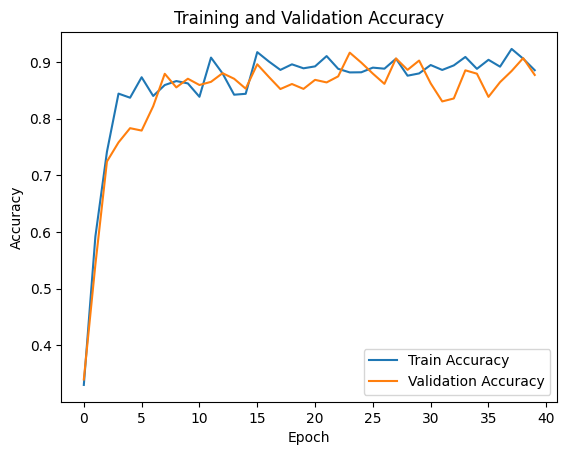

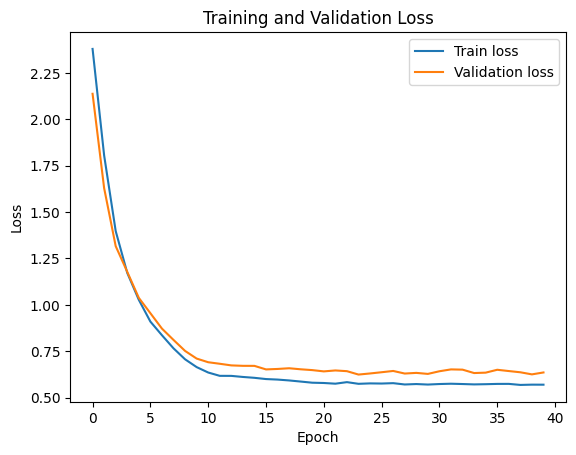

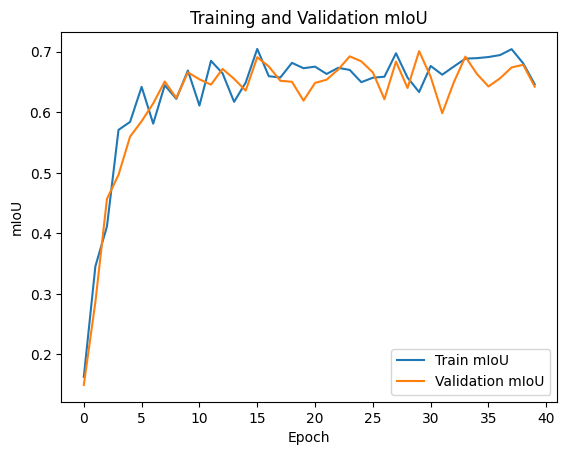

In [ ]:
plt.figure()
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.legend()

plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.title('Training and Validation Accuracy')

plt.figure()
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Validation loss")

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

plt.figure()
plt.plot(train_mIoUs, label="Train mIoU")
plt.plot(val_mIoUs, label="Validation mIoU")

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('mIoU')
plt.title('Training and Validation mIoU')

# Evaluation

In [ ]:
best_val_model_path = './Pre-Trained_Models/best_val_checkpoint_norm_aug_tensorboard.pth'
best_val_checkpoint = torch.load(best_val_model_path, map_location=torch.device(device))
# Before loading the state_dict of the model, make sure the "model" instance is 
# initiated by its corresponding class e.g. VGG16
model.load_state_dict(best_val_checkpoint['model'])

<All keys matched successfully>

In [ ]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_test = A.Compose([A.Resize(256, 256, interpolation=cv2.INTER_NEAREST)])
test_set = CityDataset(IMAGE_PATH_TEST, MASK_PATH_TEST, X_test, mean, std, t_test)

In [ ]:
test_set

In [ ]:
# test_set = val_set

In [ ]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    # t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    # image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [ ]:
def test_miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [ ]:
test_set[1]

(tensor([[[-1.1932, -1.1075, -1.0562,  ..., -0.3198, -0.0629, -0.0801],
          [-1.1589, -1.1418, -1.0048,  ..., -0.8507,  0.8961,  0.2796],
          [-1.0904, -1.1418, -0.9705,  ...,  1.1529,  1.1700, -0.0972],
          ...,
          [-1.5357, -1.5014, -1.5357,  ..., -1.5185, -1.5185, -1.3130],
          [-1.5014, -1.5185, -1.5185,  ..., -1.4843, -1.5014, -1.4500],
          [-1.5357, -1.5185, -1.4843,  ..., -1.4500, -1.4500, -1.5014]],
 
         [[-1.0378, -0.8627, -0.7752,  ..., -0.0574,  0.1702,  0.1352],
          [-1.0028, -0.8978, -0.7227,  ..., -0.6001,  1.3431,  0.7479],
          [-0.9853, -0.9503, -0.7227,  ...,  1.4832,  1.7983,  0.3452],
          ...,
          [-1.3704, -1.3354, -1.3704,  ..., -1.3354, -1.2829, -1.0728],
          [-1.3354, -1.3529, -1.3529,  ..., -1.3004, -1.3179, -1.2654],
          [-1.3880, -1.3704, -1.3529,  ..., -1.2654, -1.2654, -1.3179]],
 
         [[-0.6715, -0.5321, -0.4624,  ...,  0.3045,  1.5942,  1.4374],
          [-0.6367, -0.5670,

In [ ]:
mob_miou = test_miou_score(model, test_set)
np.mean(mob_miou)

  0%|          | 0/101 [00:00<?, ?it/s]

0.689513820932323

In [ ]:
def display_for_comparison(image, mask, pred_mask):
  image = image.numpy().transpose(1,2,0)

  fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
  ax1.imshow(image)
  ax1.set_title('Picture');

  ax2.imshow(mask)
  ax2.set_title('Ground truth')
  ax2.set_axis_off()

  ax3.imshow(pred_mask)
  ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score))
  ax3.set_axis_off()

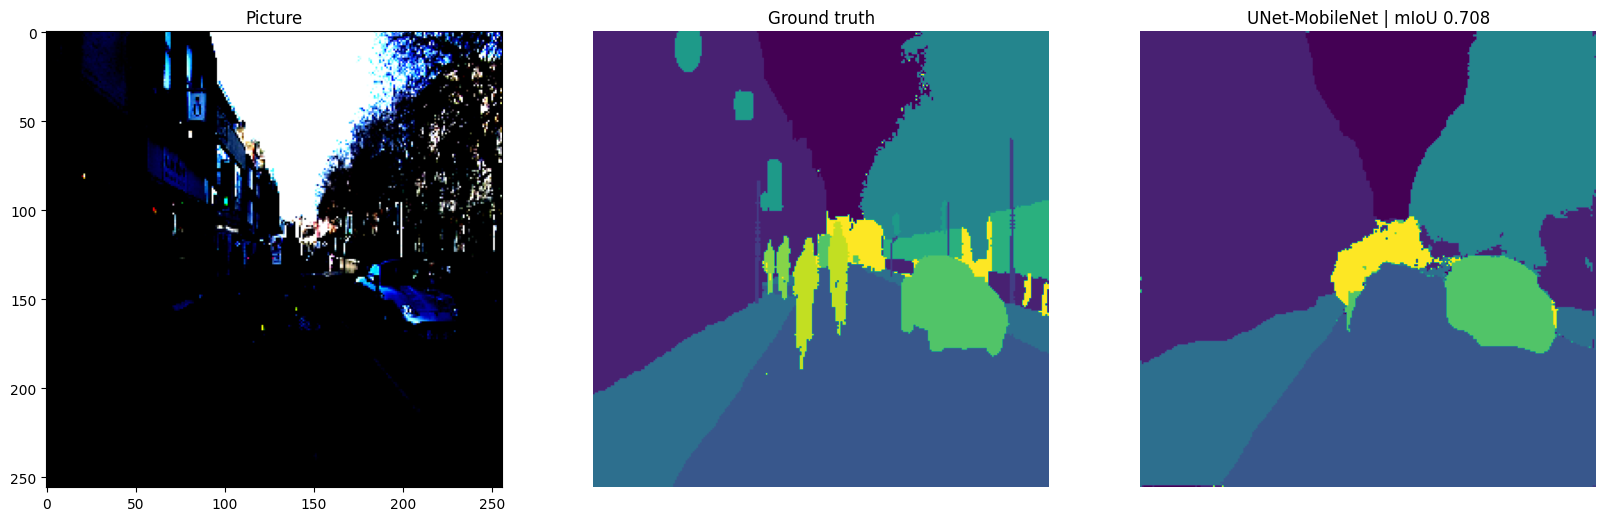

In [ ]:
image, mask = test_set[3]
pred_mask, score = predict_image_mask_miou(model, image, mask)

display_for_comparison(image, mask, pred_mask)

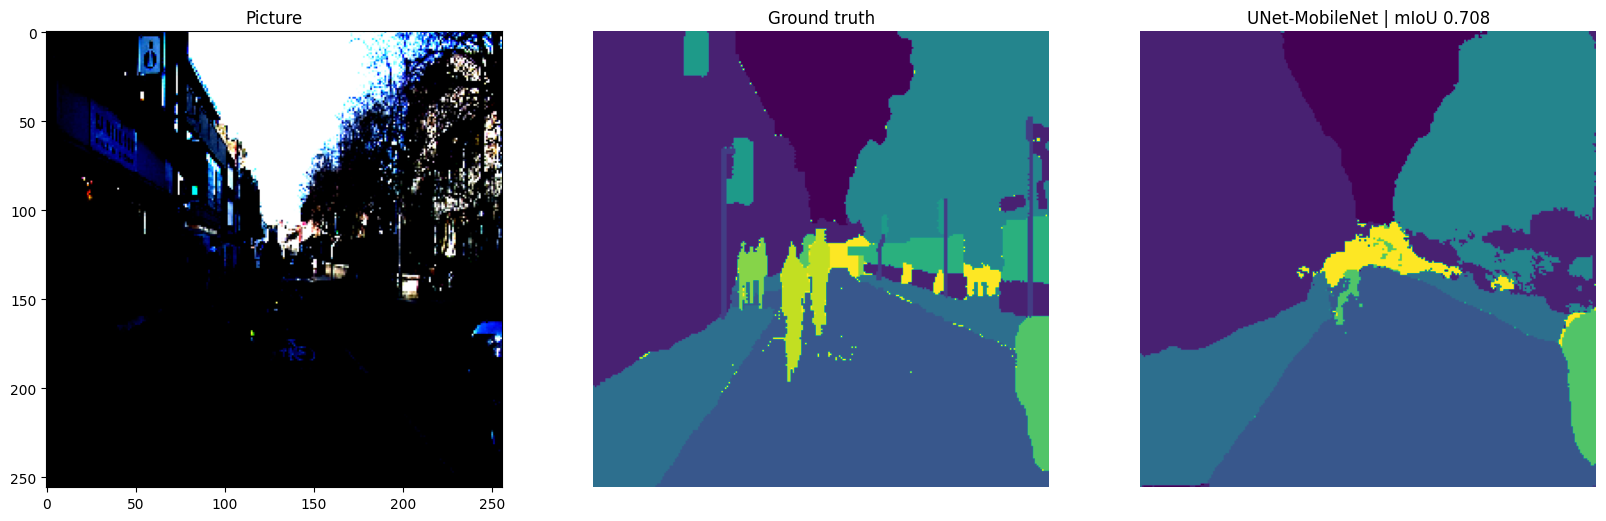

In [ ]:
image2, mask2 = test_set[9]
pred_mask2, score2 = predict_image_mask_miou(model, image2, mask2)


display_for_comparison(image2, mask2, pred_mask2)

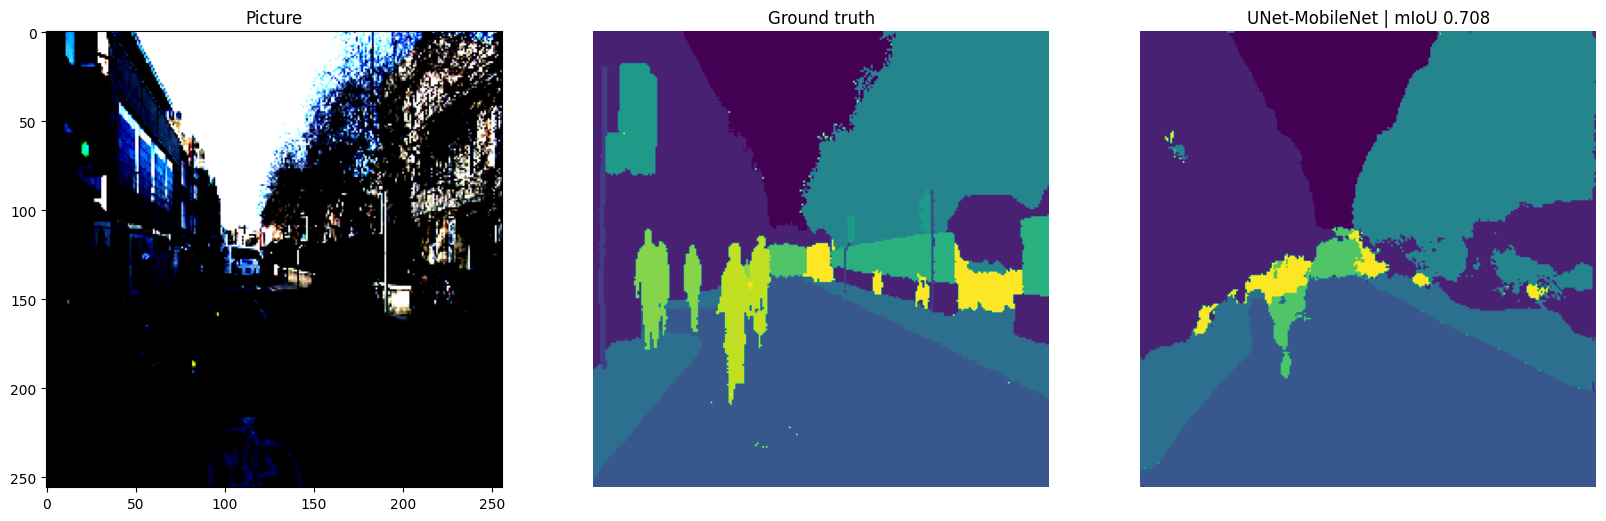

In [ ]:
image3, mask3 = test_set[15]
pred_mask3, score3 = predict_image_mask_miou(model, image3, mask3)


display_for_comparison(image3, mask3, pred_mask3)

In [ ]:
import torch
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, recall_score

# Assuming you have a test_set DataLoader and a trained model
test_results = []

for image, mask in test_set:
    # Assuming you have a function predict_image_mask_miou() that returns the predicted mask and score
    pred_mask, score = predict_image_mask_miou(model, image, mask)

    # Convert tensors to numpy arrays
    mask_np = mask.numpy()
    pred_mask_np = pred_mask.numpy()

    # Calculate metrics for each class
    f1_scores = []
    accuracies = []
    sensitivities = []
    num_classes = pred_mask_np.shape[0]
    for class_id in range(num_classes):
        mask_class = mask_np[class_id].flatten()
        pred_mask_class = pred_mask_np[class_id].flatten()

        f1_scores.append(f1_score(mask_class, pred_mask_class, average='weighted'))
        accuracies.append(accuracy_score(mask_class, pred_mask_class))
        sensitivities.append(recall_score(mask_class, pred_mask_class, average='weighted'))

    # Average the metrics across all classes
    f1 = np.mean(f1_scores)
    accuracy = np.mean(accuracies)
    sensitivity = np.mean(sensitivities)

    # Append the metrics to the test_results list
    test_results.append({'F1 Score': f1, 'Accuracy': accuracy, 'Sensitivity': sensitivity})

# Print the test results
for i, result in enumerate(test_results):
    print(f"Image {i+1}:")
    print("F1 Score:", result['F1 Score'])
    print("Accuracy:", result['Accuracy'])
    print("Sensitivity:", result['Sensitivity'])
    print()

# Save the test_results list
np.save('test_results.npy', test_results)


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1

Image 1:
F1 Score: 0.8648666694218987
Accuracy: 0.89031982421875
Sensitivity: 0.89031982421875

Image 2:
F1 Score: 0.8724539371876533
Accuracy: 0.8917694091796875
Sensitivity: 0.8917694091796875

Image 3:
F1 Score: 0.8160836630993615
Accuracy: 0.83929443359375
Sensitivity: 0.83929443359375

Image 4:
F1 Score: 0.8646457001660308
Accuracy: 0.893035888671875
Sensitivity: 0.893035888671875

Image 5:
F1 Score: 0.867852578607779
Accuracy: 0.89117431640625
Sensitivity: 0.89117431640625

Image 6:
F1 Score: 0.8311815348206787
Accuracy: 0.8536529541015625
Sensitivity: 0.8536529541015625

Image 7:
F1 Score: 0.8126601699560793
Accuracy: 0.8360137939453125
Sensitivity: 0.8360137939453125

Image 8:
F1 Score: 0.8361130142001666
Accuracy: 0.85699462890625
Sensitivity: 0.85699462890625

Image 9:
F1 Score: 0.8489991455510243
Accuracy: 0.869049072265625
Sensitivity: 0.869049072265625

Image 10:
F1 Score: 0.8337287752843816
Accuracy: 0.8618927001953125
Sensitivity: 0.8618927001953125

Image 11:
F1 Score: 

In [ ]:
import torch
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score

# Assuming you have a test_set DataLoader and a trained model
test_results = []

for image, mask in test_set:
    # Assuming you have a function predict_image_mask_miou() that returns the predicted mask and score
    pred_mask, score = predict_image_mask_miou(model, image, mask)

    # Convert tensors to numpy arrays
    mask_np = mask.numpy()
    pred_mask_np = pred_mask.numpy()

    # Calculate metrics for each class
    dice_scores = []
    specificity_scores = []
    num_classes = pred_mask_np.shape[0]
    for class_id in range(num_classes):
        mask_class = mask_np[class_id].flatten()
        pred_mask_class = pred_mask_np[class_id].flatten()

        intersection = np.logical_and(mask_class, pred_mask_class)
        dice_score = 2 * np.sum(intersection) / (np.sum(mask_class) + np.sum(pred_mask_class))
        dice_scores.append(dice_score)

        true_negatives = np.logical_and(1 - mask_class, 1 - pred_mask_class)
        specificity_score = np.sum(true_negatives) / np.sum(1 - mask_class)
        specificity_scores.append(specificity_score)

    # Average the metrics across all classes
    dice = np.mean(dice_scores)
    specificity = np.mean(specificity_scores)

    # Append the metrics to the test_results list
    test_results.append({'Dice Score': dice, 'Specificity': specificity})

# Print the test results
for i, result in enumerate(test_results):
    print(f"Image {i+1}:")
    print("Dice Score:", result['Dice Score'])
    print("Specificity:", result['Specificity'])
    print()

# Save the test_results list
np.save('test_results.npy', test_results)


Image 1:
Dice Score: 0.3275207013782844
Specificity: -0.4070144715226568

Image 2:
Dice Score: 0.321897303293282
Specificity: -0.38507248273660544

Image 3:
Dice Score: 0.28305289759557917
Specificity: -0.35478766620480556

Image 4:
Dice Score: 0.3109670647036319
Specificity: -0.37391902116807996

Image 5:
Dice Score: 0.3251628890783189
Specificity: -0.40690549939834186

Image 6:
Dice Score: 0.28797149951423945
Specificity: -0.37225245444669564

Image 7:
Dice Score: 0.2828978618109146
Specificity: -0.35564592236277953

Image 8:
Dice Score: 0.2874257593856417
Specificity: -0.37879299269763533

Image 9:
Dice Score: 0.2973509556148658
Specificity: -0.3617895934333746

Image 10:
Dice Score: 0.31116682725197076
Specificity: -0.3687396846136659

Image 11:
Dice Score: 0.3013321142585556
Specificity: -0.38367409892563725

Image 12:
Dice Score: 0.332281082676281
Specificity: -0.41899145913637914

Image 13:
Dice Score: 0.33678453477983145
Specificity: -0.40876021660037987

Image 14:
Dice Score: 

In [ ]:
print("Performance measures Task 1 ((F1 Score, Dice, Accuracy, Sensitivity and Specificity)):")
print("F1 Score:", f1)
print("Accuracy:", accuracy)
print("Sensitivity:", sensitivity)
print("Dice Score:", dice)
print("Specificity:",  specificity)

Performance measures Task 1 ((F1 Score, Dice, Accuracy, Sensitivity and Specificity)):
F1 Score: 0.8705685814598437
Accuracy: 0.8916778564453125
Sensitivity: 0.8916778564453125
Dice Score: 0.3303533621660636
Specificity: -0.38809499731254893
